In [18]:
import sys
import importlib

sys.path.append("../")

from src import utils
from src.utils import *

from src import plot_utils
from src import graph_utils
from src import inpaint_utils
from src import fiberatlas_utils

## Goal

The goal of this notebook is to do inpainting. Allowing for negative weightings of bundle to generate bundles, and allowing as well negatively connected bundles to exist

## Description



- Scale1 -> ~95
- Scale2 -> ~140
- Scale3 -> ~240

Structuring of folder h5: 
- ['atlas', 'header', 'matrices']:
    - atlas:
        - bundles 10-59
        - bundles 11-23
        - ...
    - header: 
        - affine, dim, gmcodes, gmcolors, gmcoords, gmregions, nsubjects, voxsize
    - matrices:
        - consistency
        - length
        - numbStlines

In [19]:
scale = 3
connFilename = f'../../atlas_data/fiber_atlas/probconnatlas/wm.connatlas.scale{scale}.h5'
hf = h5py.File(connFilename, 'r')

centers = np.array(hf.get('header').get('gmcoords'))
nsubject = hf.get('header').get('nsubjects')[()]
dim = hf.get('header').get('dim')[()]
fiber_affine = hf.get('header').get('affine')[()]

gmregions_names = hf.get('header').get('gmregions')[()]
nb_regions = gmregions_names.shape[0]

# NOTE; use the masks if necessary when 
# we select too much bundles for reconstruction
gm_mask_subj = nib.load('../../atlas_data/moviedata_fMRI_eg/gm_mask_subj7.nii').get_fdata() 
wm_mask_subj = (gm_mask_subj + 1) % 2


consistency_view = fiberatlas_utils.get_aggprop(hf, 'consistency')
length_view = fiberatlas_utils.get_aggprop(hf, 'length')
nbStlines_view = fiberatlas_utils.get_aggprop(hf, 'numbStlines')
nb_regions = consistency_view.shape[0]

# region_of_interest = ['ctx-rh-posteriorcingulate', 'ctx-lh-posteriorcingulate']
# index_of_interest = [np.where(gmregions_names.astype(str) == r)[0][0] 
#                      for r in region_of_interest]

# index_of_interest = np.array(index_of_interest)
# gmregions_names[index_of_interest]

## Regressing Bundle Activities

In [20]:
# NOTE: consider bundles that appear at least in 30 % of the subjects
thresh_subjapp = int(np.ceil(nsubject * 0.1)) 

### Building desing matrix
- Binary
- Voxel probability accounting

In [21]:
# GENERATING ORIGINAL - without caring about voxel percentage
# Generating the X samples and the y samples
# 1. Careful as well to remove the auto-correlation in the diagonal
# 2. Raster scan parsing meaning that it is the activity of (R0,R1) -> (R0,R2) -> (R0,R3) etc...
# Define matrix of end points on cortex
X = []
bundles_labels = []
for i in tqdm(range(1,nb_regions + 1)):
    for j in range(i,nb_regions + 1):
        tmp = fiberatlas_utils.get_bundles_betweenreg(hf, i, j, verbose=False)
        if tmp is None: continue
        if np.sum(tmp[:,3] >= (thresh_subjapp)) == 0: continue
        bundles_labels.append((i,j))
        vec = np.zeros(nb_regions)
        vec[i-1] = 1.0
        vec[j-1] = 1.0
        X.append(vec)

X = np.array(X)

100%|██████████| 243/243 [24:31<00:00,  6.05s/it]


In [22]:
# GENERATING caring about voxel percentage

root = '../../atlas_data/fiber_atlas/yasser_datacomp/volspams_compress/'

atlas_of_interest = f'compresslausanne2018.scale{scale}.sym.corrected.ctx+subc.volspams.nii.gz'

prob_regions, prob_affine = (nib.load(root + atlas_of_interest).get_fdata()[:,:,:,1:], 
                             nib.load(root + atlas_of_interest).affine)

Xp = []
bundles_labels = []
for i in tqdm(range(1,nb_regions + 1)):
    for j in range(i,nb_regions + 1):
        tmp = fiberatlas_utils.get_bundles_betweenreg(hf, i, j, verbose=False)
        if tmp is None: continue
        if np.sum(tmp[:,3] >= (thresh_subjapp)) == 0: continue
        bundle_coords = tmp[:,[0,1,2]]

        prob_vox = np.zeros_like(prob_regions[:,:,:,0])
        prob_vox[bundle_coords[:,0], bundle_coords[:,1], bundle_coords[:,2]] = 1.0

        region_i = prob_regions[:,:,:,i-1]
        region_j = prob_regions[:,:,:,j-1]

        bundle_proba_i = (region_i * prob_vox)
        bproba_i = bundle_proba_i[bundle_proba_i!=0].mean()
        bundle_proba_j = (region_j * prob_vox)
        bproba_j = bundle_proba_j[bundle_proba_j!=0].mean()

        bundles_labels.append((i,j))
        vec = np.zeros(nb_regions)
        vec[i-1] = bproba_i
        vec[j-1] = bproba_j
        Xp.append(vec)

Xp = np.array(Xp)
Xp = np.nan_to_num(Xp)

 44%|████▍     | 108/243 [29:02<22:43, 10.10s/it] /tmp/ipykernel_125093/3045406840.py:26: RuntimeWarning: Mean of empty slice.
  bproba_i = bundle_proba_i[bundle_proba_i!=0].mean()
/home/chchan/miniconda3/envs/microstruct_atlas/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 243/243 [45:17<00:00, 11.18s/it]


In [23]:
region_ftimecourse = load(f"../../atlas_data/moviedata_fMRI_eg/yasseratlased_fmri/ftimecourse_95_scale{scale}.pkl")
regions_in_voxels = load(f'../../atlas_data/fiber_atlas/regions95_voxels_scale{scale}.pkl')[:,:,:,1:]

### Regressing L1 - L2

In [41]:
regularizers = np.sort(np.concatenate([np.logspace(0,5,6), np.logspace(0,5,6) / 2]))

perf_ridge = {'coefs': [],'scores': [], 'intercepts': []}
for k in tqdm(range(len(regularizers))):
    coefs, scores, intercepts = inpaint_utils.regress_linear(X, region_ftimecourse, 
                                                            regularizers[k], ridgeflag=True, verbose=False)
    perf_ridge['coefs'].append(coefs)
    perf_ridge['scores'].append(scores)
    perf_ridge['intercepts'].append(intercepts)

perf_lasso = {'coefs': [],'scores': [], 'intercepts': []}
for k in tqdm(range(len(regularizers))):
    coefs, scores, intercepts = inpaint_utils.regress_linear(X, region_ftimecourse, 
                                                            regularizers[k], ridgeflag=False, verbose=False)
    perf_lasso['coefs'].append(coefs)
    perf_lasso['scores'].append(scores)
    perf_lasso['intercepts'].append(intercepts)

100%|██████████| 12/12 [04:18<00:00, 21.56s/it]


### Generating time varying vertex graph
The rational generating time varying vertex graph is to exploit time relationship in fMRI.

Graph generation conditions:
- The nodes are the atlased regions while the edges are connected when bundles have a commonly shared region
- We then duplicate such a graph in time

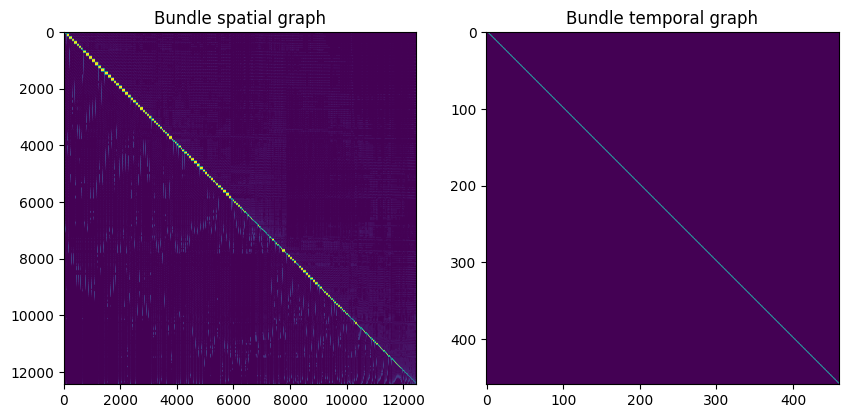

In [24]:
# spatial graph defining
bundle_graph = np.zeros((X.shape[0], X.shape[0]))
for k in range(X.shape[0]):
    avect1 = X[k]
    for s in range(X.shape[0]):
        if s == k: continue
        avect2 = X[s]
        if np.abs(avect1 - avect2).sum() <= 2:
            bundle_graph[k,s] = 1.0
            bundle_graph[s,k] = 1.0

# temporal graph defining
cycle = graph_utils.make_cycle(region_ftimecourse.shape[-1])

Ls = graph_utils.compute_directed_laplacian(bundle_graph)
Lt = graph_utils.compute_directed_laplacian(cycle)

fig, ax = plt.subplots(1,2, figsize=(10, 10))

ax[0].set_title('Bundle spatial graph')
ax[1].set_title('Bundle temporal graph')
ax[0].imshow(bundle_graph)
ax[1].imshow(cycle)

In [25]:
Xmult = np.array([Xp.T for _ in range(region_ftimecourse.shape[-1])])

bundle_opt, logs = inpaint_utils.optimize_lreg(Xmult, region_ftimecourse, Ls=Ls, Lt=Lt, 
                                               verbose=True, num_epochs=200, logging=True, p1=0, p2=0, lr=1)
bundle_opt_saturate, logs_saturate = inpaint_utils.optimize_lreg(Xmult, region_ftimecourse, Ls=Ls, Lt=Lt, 
                                 verbose=True, num_epochs=1, logging=True, p1=1e-1, p2=1e-1, lr=1,
                                saturate=True, saturate_factor=0.85)

100%|██████████| 200/200 [18:00<00:00,  5.40s/it]


Losses are decomposed into:
generic loss=tensor([0.6916])
spatialloss=tensor([10657166.])
temporalloss=tensor([12104.2012])
sumloss=tensor([0.6916])


100%|██████████| 1/1 [00:24<00:00, 24.66s/it]


Losses are decomposed into:
generic loss=tensor([116452.6562])
spatialloss=tensor([3351443.2500])
temporalloss=tensor([4023.2781])
sumloss=tensor([451999.3125])


0.06147525790862514
0.0001498195623295712


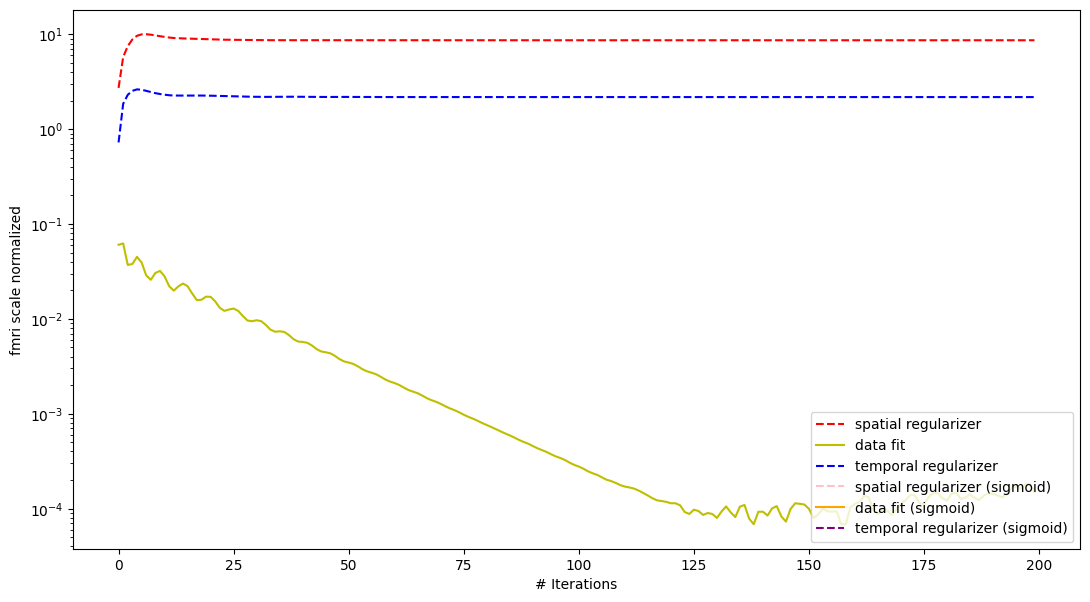

In [29]:
scalenorm = np.abs(region_ftimecourse).mean()
meandeg = bundle_graph.sum(axis=0).astype(float).mean()

datafit_loss = np.sqrt(np.array(logs['gen_loss'])) / region_ftimecourse.shape[-1] / scalenorm
spatial_reg_loss = np.array(logs['spatial_reg_loss']) / (bundle_opt.shape[0] * meandeg) / scalenorm 
temporal_reg_loss = np.array(logs['temporal_reg_loss']) / region_ftimecourse.shape[-1] / scalenorm

datafit_loss_sat = np.sqrt(np.array(logs_saturate['gen_loss'])) / region_ftimecourse.shape[-1] / scalenorm
spatial_reg_loss_sat = np.array(logs_saturate['spatial_reg_loss']) / (bundle_opt.shape[0] * meandeg) / scalenorm 
temporal_reg_loss_sat = np.array(logs_saturate['temporal_reg_loss']) / region_ftimecourse.shape[-1] / scalenorm

time_horizon = 200
plt.figure(figsize=(13,7))
plt.plot(spatial_reg_loss[:time_horizon], color='r', linestyle='--', label='spatial regularizer')
plt.plot(datafit_loss[:time_horizon], color='y', label='data fit')
plt.plot(temporal_reg_loss[:time_horizon], color='b', linestyle='--', label='temporal regularizer')

plt.plot(spatial_reg_loss_sat[:time_horizon], color='pink', linestyle='--', label='spatial regularizer (sigmoid)')
plt.plot(datafit_loss_sat[:time_horizon], color='orange', label='data fit (sigmoid)')
plt.plot(temporal_reg_loss_sat[:time_horizon], color='purple', linestyle='--', label='temporal regularizer (sigmoid)')
plt.legend(loc='lower right')
plt.yscale('log')
plt.ylabel('fmri scale normalized')
plt.xlabel('# Iterations')
print(datafit_loss_sat[-1])
print(datafit_loss[-1])

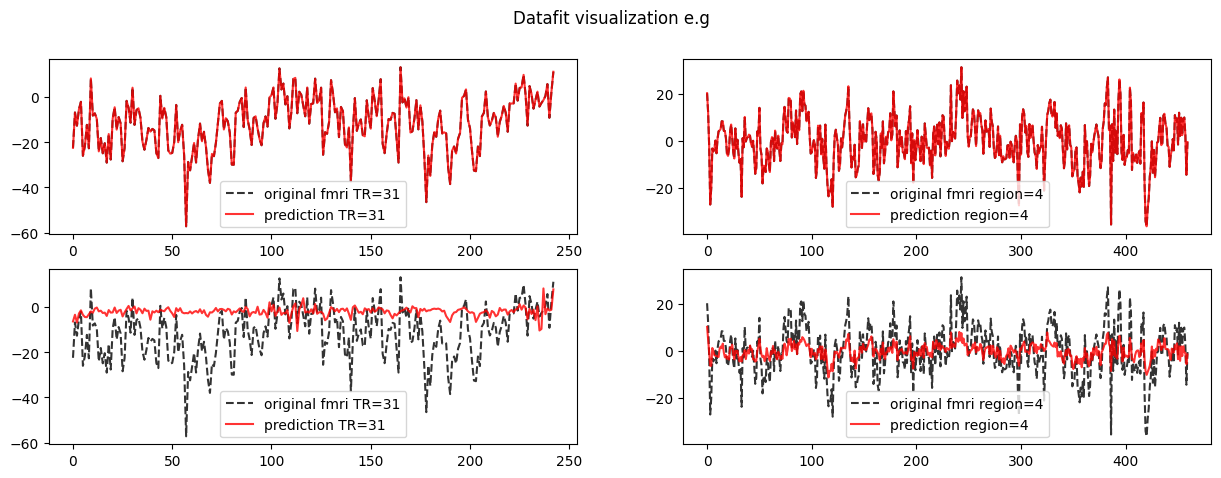

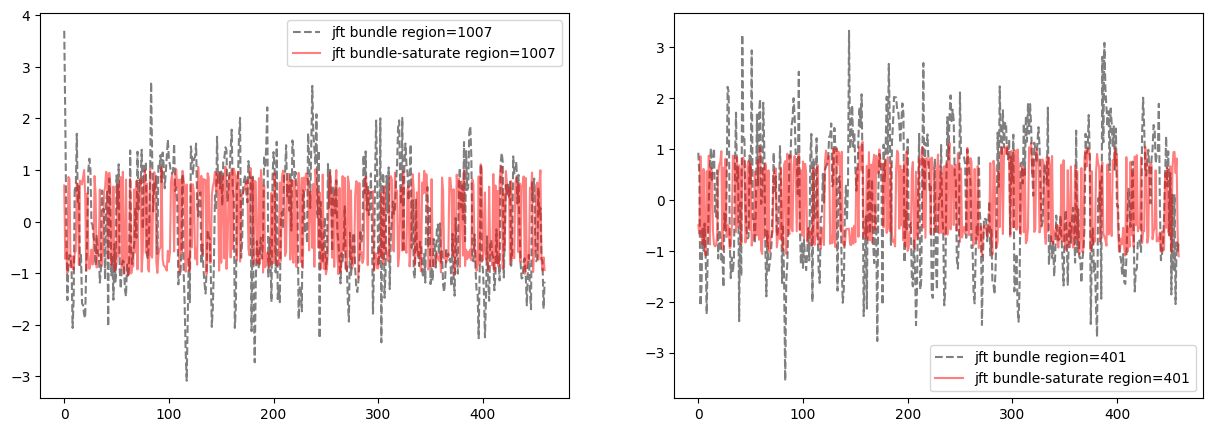

In [27]:
fig, ax = plt.subplots(2,2, figsize=(15,5))
cidx = 30
plt.suptitle('Datafit visualization e.g')
for pidx in range(2):
    bundle = [bundle_opt, bundle_opt_saturate][pidx]
    ax[pidx, 0].plot(region_ftimecourse[:, cidx], c='k', linestyle='--', label=f'original fmri TR={cidx+1}', alpha=0.8)
    tmp = torch.Tensor(Xmult[cidx] @ bundle[cidx])
    ax[pidx, 0].plot(tmp, c='r', label=f'prediction TR={cidx+1}', alpha=0.8)
    ax[pidx, 0].legend()

    vidx = 3

    rec_timecourse = np.zeros((len(Xmult)))
    for k in range(len(Xmult)):
        tmp = Xmult[k] @ bundle[k]
        rec_timecourse[k] = tmp[vidx]

    ax[pidx, 1].plot(region_ftimecourse[vidx], c='k', linestyle='--', label=f'original fmri region={vidx+1}', alpha=0.8)
    ax[pidx, 1].plot(rec_timecourse, c='r', label=f'prediction region={vidx+1}', alpha=0.8)
    ax[pidx, 1].legend()


fig, ax = plt.subplots(1,2, figsize=(15,5))
vidx = [1006, 400]

for k in range(2):
    # ax[k].plot(np.array(perf_ridge['coefs'])[:,3,vidx[k]], c='r', label=f'ridge bundle region={vidx[k]+1}', alpha=0.8)
    # ax[k].plot(range11(np.array(perf_lasso['coefs'])[:,3,vidx[k]]), c='b', label=f'lasso bundle region={vidx[k]+1}', alpha=0.3)
    ax[k].plot(bundle_opt[:,vidx[k]], c='k', label=f'jft bundle region={vidx[k]+1}', alpha=0.5, linestyle='--')
    ax[k].plot(bundle_opt_saturate[:,vidx[k]], c='r', label=f'jft bundle-saturate region={vidx[k]+1}', alpha=0.5)
    ax[k].legend()
    # ax[k].set_yscale('log')

plt.show()

In [28]:
# save(f"../resources/weight_regressors_activity/vweighted_bundle_activity_lasso{thresh_subjapp}.pkl", perf_lasso)
# save(f"../resources/weight_regressors_activity/vweighted_bundle_activity_ridge{thresh_subjapp}.pkl", perf_ridge)
save(f"../resources/weight_regressors_activity/vweighted_bundle_activity_timevertex{thresh_subjapp}_scale{scale}.pkl", bundle_opt)
# save(f"../resources/weight_regressors_activity/bundle_activity_timevertex_saturate{thresh_subjapp}.pkl", bundle_opt_saturate)

## Reconstruction of the fMRI timecourses in WM bundles / voxels levels

- Bring back the GM voxel level timecourses
- Assign timecourse value on voxel being the weighted value of a voxel (so can regenerate WM volumes first then average)
- Recompute the seed connectivity of a given region versus all and show it on the volume (voxel levels)

In [30]:
bundle_affine = np.array(hf.get('header').get('affine'))[()]

voxel_fmri = nib.load('../../atlas_data/moviedata_fMRI_eg/movie_group_fmri.nii')
vdim = voxel_fmri.shape[:3]
rest_affine = voxel_fmri.affine

Making Access easier - transforming bundles to fmri coordinates / fmri volumes masks

In [31]:
trans_affine = np.matmul(np.linalg.inv(rest_affine), bundle_affine)

fmri_coords = []
for k in tqdm(range(len(bundles_labels))):
    i,j = bundles_labels[k]
    streamline = fiberatlas_utils.get_bundles_betweenreg(hf, i,j)
    streamline = streamline[streamline[:,3] >= thresh_subjapp]

    # Transform voxel indexes of a volume to voxel index of another volume
    volcoords_interest = volcoord2mnicoord(streamline[:,[0,1,2]], trans_affine).astype(int)
    volcoords_interest = np.concatenate([volcoords_interest, streamline[:,[3]]/nsubject], axis=1)

    fmri_coords.append(volcoords_interest)

# Save the space coords matching
save(f'../resources/scale{scale}_fmri2atlas_coords_div{int(np.ceil(thresh_subjapp))}.pkl', fmri_coords)

  0%|          | 0/12442 [00:00<?, ?it/s]

100%|██████████| 12442/12442 [10:21<00:00, 20.02it/s]


In [32]:
fmri_coords = load(f'../resources/scale{scale}_fmri2atlas_coords_div{int(np.ceil(thresh_subjapp))}.pkl')

### Load optimized white bundles

In [14]:
# perf_lasso = load(f"../resources/weight_regressors_activity/bundle_activity_lasso{thresh_subjapp}.pkl")
# perf_ridge = load(f"../resources/weight_regressors_activity/bundle_activity_ridge{thresh_subjapp}.pkl")
# bundle_opt = load(f"../resources/weight_regressors_activity/bundle_activity_timevertex{thresh_subjapp}.pkl")
# bundle_opt_saturate = load(f"../resources/weight_regressors_activity/bundle_activity_timevertex_saturate{thresh_subjapp}.pkl")

### Interpolate the connectivity of WM bundles at voxel levels

In [33]:
# wm_inpainted_lasso, wm_inpainted_lassoM = interpolate_activity(fmri_coords, bundles_labels, np.array(perf_lasso['coefs'])[0,1], vdim, wmmask=wm_mask_subj, normalizing=True)
# wm_inpainted_ridge, wm_inpainted_ridgeM = interpolate_activity(fmri_coords, bundles_labels, np.array(perf_ridge['coefs'])[0,1], vdim, wmmask=wm_mask_subj, normalizing=True)

# wm_inpainted_lpos, wm_inpainted_lposM = interpolate_activity(fmri_coords, bundles_labels, bundle_opt_pos[0], vdim, wmmask=wm_mask_subj, normalizing=True)
# wm_inpainted_lneg, wm_inpainted_lnegM = interpolate_activity(fmri_coords, bundles_labels, bundle_opt_neg[0], vdim, wmmask=wm_mask_subj, normalizing=True)
# wm_inpainted_lall, wm_inpainted_lallM = interpolate_activity(fmri_coords, bundles_labels, bundle_opt_pos[0] - bundle_opt_neg[0], vdim, wmmask=wm_mask_subj, normalizing=True)

wm_inpainted_lreg, wm_inpainted_lregM = inpaint_utils.interpolate_activity(fmri_coords, bundles_labels, bundle_opt[0], vdim, wmmask=wm_mask_subj, normalizing=True)
# wm_inpainted_lsat, wm_inpainted_lsatM = inpaint_utils.interpolate_activity(fmri_coords, bundles_labels, bundle_opt_saturate[0], vdim, wmmask=wm_mask_subj, normalizing=True)

100%|██████████| 12442/12442 [00:02<00:00, 5154.78it/s]


### Comparing inpainting models (display only wm bundles of interest)

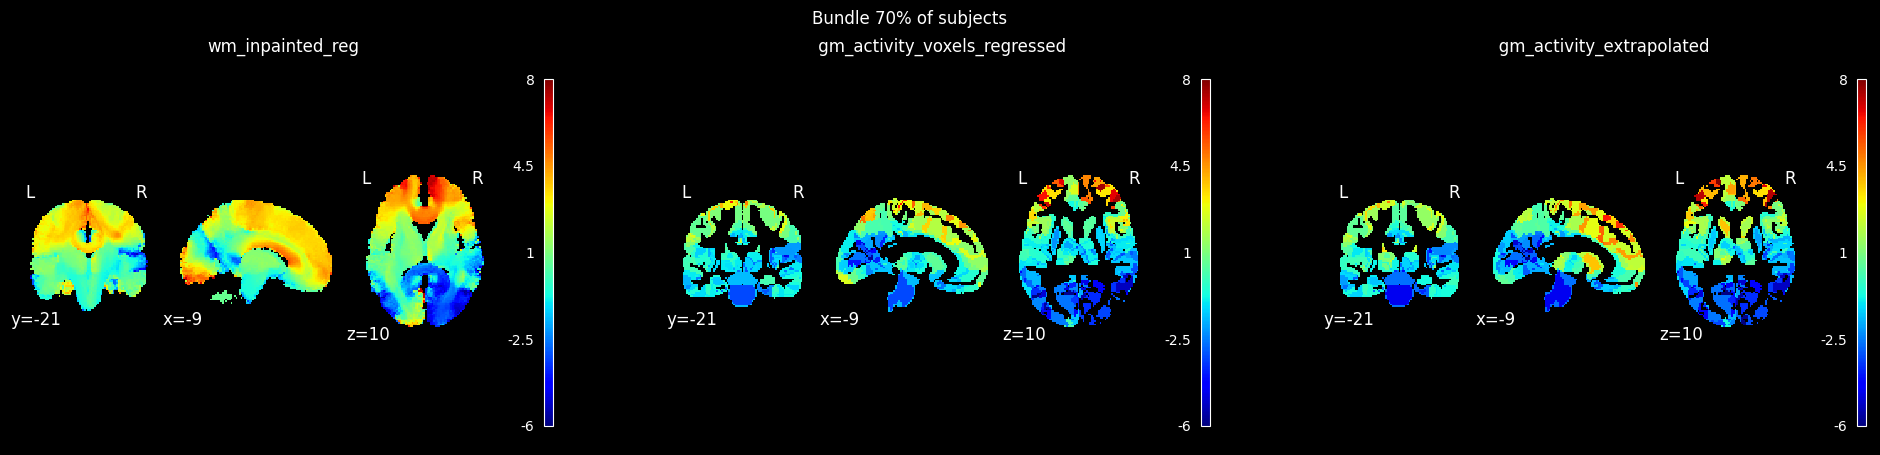

In [34]:
regressed_maps = zscore((bundle_opt @ X)[0]) * 2
frame0 = zscore(region_ftimecourse[:,0]) * 2
gm_activity_voxels = np.sum([frame0[k] * regions_in_voxels[:,:,:,k] for k in range(nb_regions)], axis=0)
gm_activity_voxels_regressed = np.sum([regressed_maps[k] * regions_in_voxels[:,:,:,k] for k in range(nb_regions)], axis=0)
gm_activity_voxels[gm_activity_voxels==0] = -100
gm_activity_voxels_regressed[gm_activity_voxels_regressed==0] = -100

inpaint_mods = [wm_inpainted_lreg, gm_activity_voxels_regressed, gm_activity_voxels]
all_inpaints_names = f'wm_inpainted_reg, gm_activity_voxels_regressed,   gm_activity_extrapolated'.split(',')

affines = [rest_affine] * 3
coords_of_interest = [(-9,-21,10)] * 3
plot_utils.plot_compare_inpainting(inpaint_mods, coords_of_interest, affines, all_inpaints_names, vmin=-6, vmax=8)

### Compute areas of good correlation against gray matter of each models

In [35]:
def volume_similarity(A:np.ndarray, B:np.ndarray):
    """ 
    Compute similarity between two volumes



    """
    ret = np.zeros((A.shape[1:]))
    for x in range(ret.shape[0]):
        for y in range(ret.shape[1]):
            for z in range(ret.shape[2]):
                ret[x,y,z] = utils.pearsonr(A[:,x,y,z], B[:, x,y,z])[0]

    ret = np.nan_to_num(ret)
    ret[ret==0] = -100

    return ret

In [36]:
tmparray_lreg = []
for k in tqdm(range(bundle_opt.shape[0])):
    tmp_inpainted, tmp_inpainted2 = inpaint_utils.interpolate_activity(fmri_coords, bundles_labels, bundle_opt[k], vdim, wmmask=wm_mask_subj, normalizing=True, verbose=False)
    tmparray_lreg.append(tmp_inpainted)
tmparray_lreg = np.array(tmparray_lreg)

100%|██████████| 460/460 [17:51<00:00,  2.33s/it]


In [37]:
tmparray_gm = []
for tidx in tqdm(range(bundle_opt.shape[0])):
    frame0 = zscore(region_ftimecourse[:,tidx])/3
    gm_activity_voxels = np.sum([frame0[k] * regions_in_voxels[:,:,:,k] 
                                 for k in range(nb_regions)],axis=0)
    gm_activity_voxels[gm_activity_voxels==0] = -100
    tmparray_gm.append(gm_activity_voxels)
tmparray_gm = np.array(tmparray_gm)

100%|██████████| 460/460 [12:32<00:00,  1.64s/it]


In [38]:
tmparray_voxel = []
tmpdata = voxel_fmri.get_fdata()
for tidx in range(bundle_opt.shape[0]):
    tmparray_voxel.append(tmpdata[:,:,:,tidx])
tmparray_voxel = np.array(tmparray_voxel)

In [44]:
similarity_gm_reg = volume_similarity(tmparray_gm, tmparray_lreg)
similarity_gm_voxel = volume_similarity(tmparray_voxel, tmparray_gm)
similarity_reg_voxel = volume_similarity(tmparray_voxel, tmparray_lreg)


/home/chchan/miniconda3/envs/microstruct_atlas/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


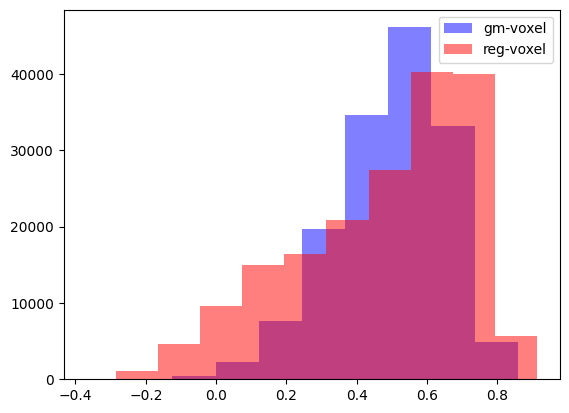

In [45]:
# plt.hist(similarity_gm_reg[similarity_gm_reg!=-100], color='k', label='unweighted', alpha=0.5)
plt.hist(similarity_gm_voxel[similarity_gm_voxel!=-100], color='b', label='gm-voxel', alpha=0.5)
plt.hist(similarity_reg_voxel[similarity_reg_voxel!=-100], color='r', label='reg-voxel', alpha=0.5)
plt.legend()

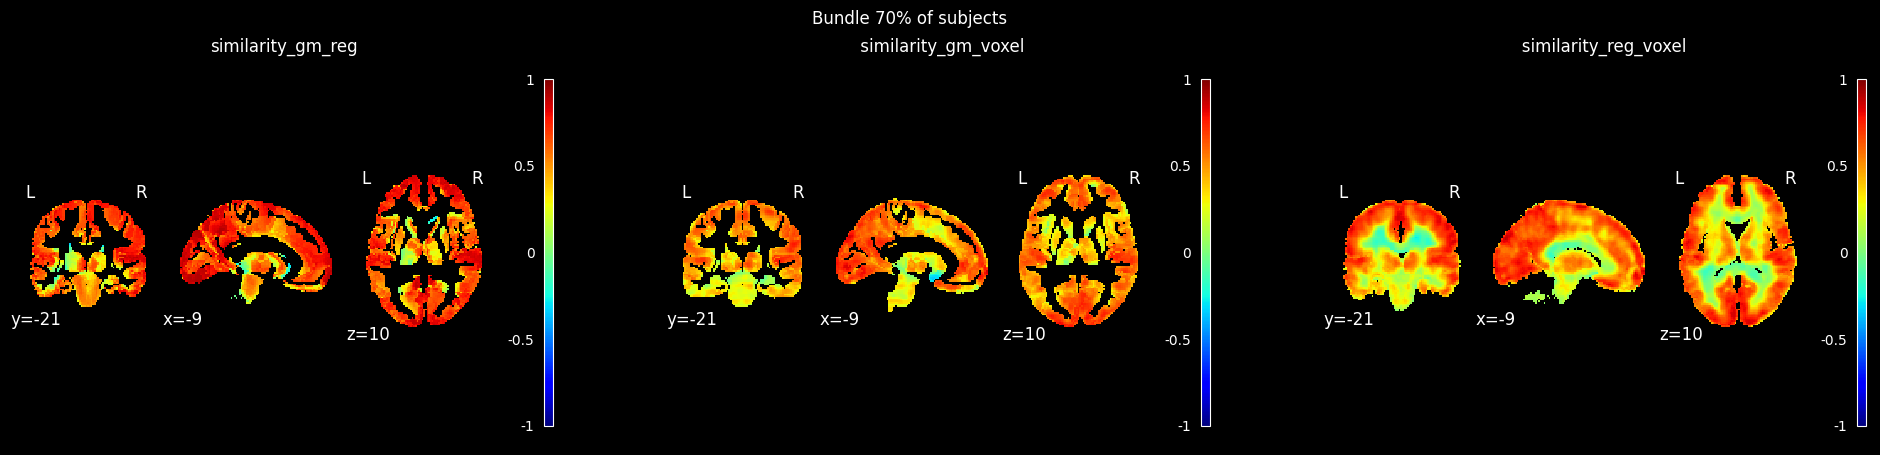

In [48]:
inpaint_mods = [similarity_gm_reg, similarity_gm_voxel, similarity_reg_voxel]
all_inpaints_names = f'similarity_gm_reg, similarity_gm_voxel,   similarity_reg_voxel'.split(',')

affines = [rest_affine] * 3
coords_of_interest = [(-9,-21,10)] * 3
plot_utils.plot_compare_inpainting(inpaint_mods, coords_of_interest, affines, all_inpaints_names, vmin=-1, vmax=1)

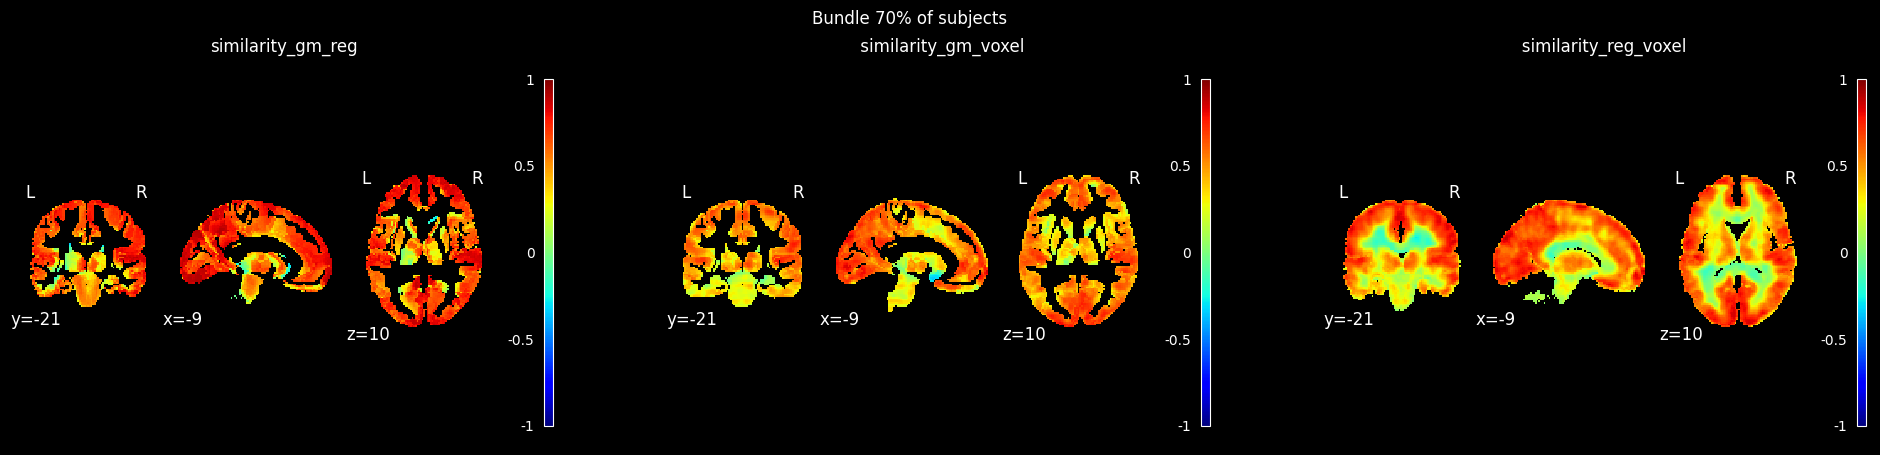

In [41]:
inpaint_mods = [similarity_gm_reg, similarity_gm_voxel, similarity_reg_voxel]
all_inpaints_names = f'similarity_gm_reg, similarity_gm_voxel,   similarity_reg_voxel'.split(',')

affines = [rest_affine] * 3
coords_of_interest = [(-9,-21,10)] * 3
plot_utils.plot_compare_inpainting(inpaint_mods, coords_of_interest, affines, all_inpaints_names, vmin=-1, vmax=1)

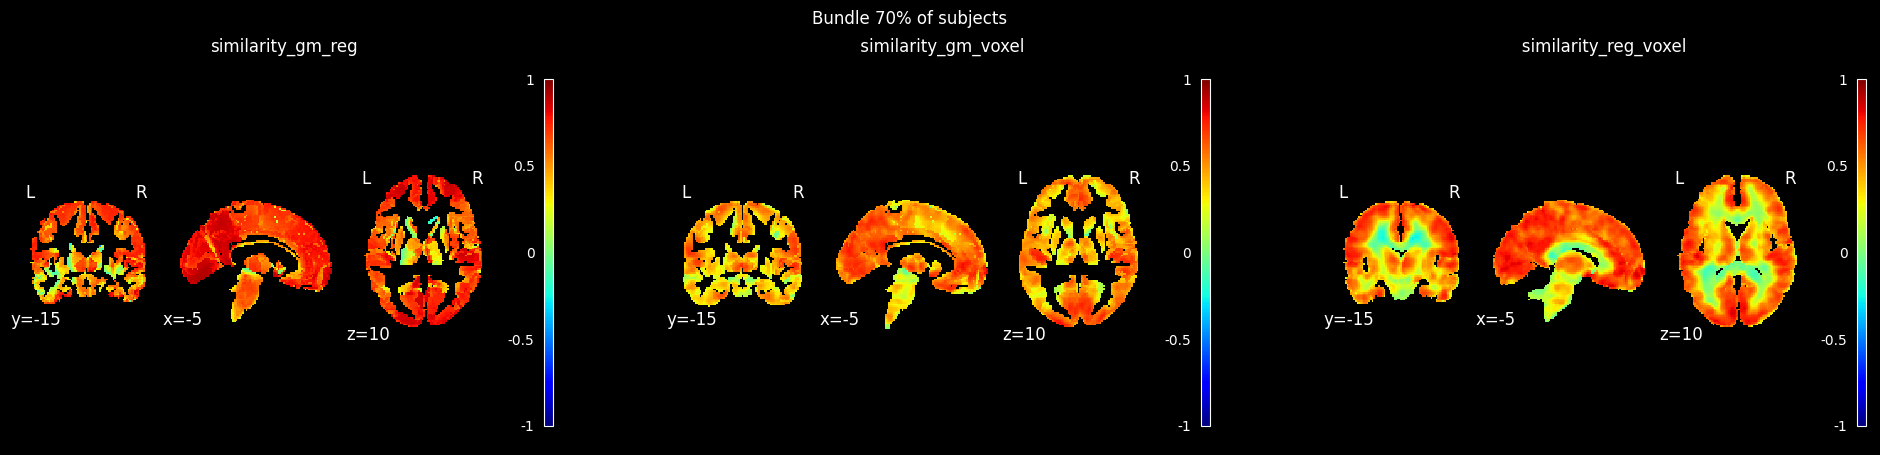

In [53]:
inpaint_mods = [similarity_gm_reg, similarity_gm_voxel, similarity_reg_voxel]
all_inpaints_names = f'similarity_gm_reg, similarity_gm_voxel,   similarity_reg_voxel'.split(',')

affines = [rest_affine] * 3
# coords_of_interest = [(-9,-21,10)] * 3
coords_of_interest = [(-5,-15,10)] * 3
plot_utils.plot_compare_inpainting(inpaint_mods, coords_of_interest, affines, all_inpaints_names, vmin=-1, vmax=1)

#### Properties of bundles (indicative information)

In [ ]:
# Using these 3 metrics we compare the goodness of spatial datafit
linegraph_degree = np.sum(bundle_graph, axis=0)
nbstlines_bundles = np.array([nbStlines_view[i-1,j-1] for (i,j) in bundles_labels])
avglength_bundles = np.array([length_view[i-1,j-1] for (i,j) in bundles_labels])

In [178]:
linegraph_vol = []
nbstlines_vol = []
avglength_vol = []
for k in tqdm(range(len(fmri_coords))):
    tmp1 = np.zeros_like(similarity_space)
    tmp2 = np.zeros_like(similarity_space)
    tmp3 = np.zeros_like(similarity_space)
    map_k = fmri_coords[k][:,:3].astype(int)
    for coord in map_k:
        tmp1[coord[0], coord[1], coord[2]] = linegraph_degree[k]
        tmp2[coord[0], coord[1], coord[2]] = nbstlines_bundles[k]
        tmp3[coord[0], coord[1], coord[2]] = avglength_bundles[k]
    
    linegraph_vol.append(tmp1)
    nbstlines_vol.append(tmp2)
    avglength_vol.append(tmp3)

linegraph_vol = np.array(linegraph_vol).mean(axis=0)
nbstlines_vol = np.array(nbstlines_vol).mean(axis=0)
avglength_vol = np.array(avglength_vol).mean(axis=0)

100%|██████████| 2586/2586 [00:50<00:00, 50.89it/s] 


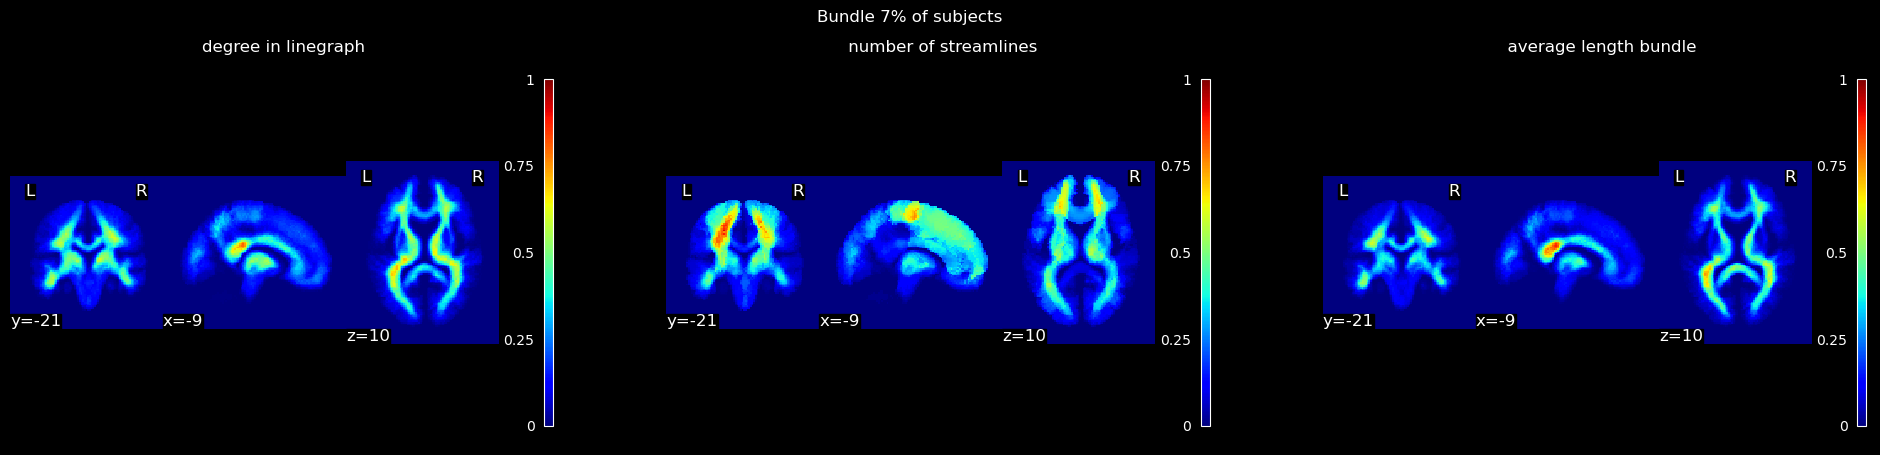

In [179]:
inpaint_mods = [linegraph_vol / linegraph_vol.max(), nbstlines_vol / nbstlines_vol.max(), avglength_vol / avglength_vol.max()]
all_inpaints_names = f'degree in linegraph, number of streamlines,  average length bundle'.split(',')

affines = [rest_affine] * 3
coords_of_interest = [(-9,-21,10)] * 3
plot_utils.plot_compare_inpainting(inpaint_mods, coords_of_interest, affines, all_inpaints_names, vmin=0, vmax=1)

In [ ]:
# NOTE: Close the opened h5 file
hf.close()